# Problem Description

The goal of this project is to develop a machine learning model capable of predicting an individual's **Quality of Life (QoL)** using behavioral, mental health, and digital usage data. Modern lifestyles are increasingly influenced by technology—daily screen time, notifications, sleep habits, study/work patterns, and social media activity are all intertwined with wellbeing. Because these factors interact in complex and nonlinear ways, traditional analytical methods struggle to capture the relationships effectively.

In this notebook, we build a predictive model that learns how various lifestyle and psychological features (such as anxiety, depression, stress, sleep quality, productivity, and digital dependence) contribute to an individual's self-reported QoL or happiness score. The data used in this project is a synthetic dataset of 3,500 participants that simulates real-world behavioral and mental health patterns.

The resulting model will later be deployed in an interactive Streamlit web application, allowing users to input their own behavioral data and receive an estimated QoL score. This demonstrates how machine learning can be applied to wellness assessment, digital behavior analytics, and personalized feedback systems.


In [12]:
# Imports
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib
import matplotlib.pyplot as plt


In [13]:
# Load Data
df = pd.read_csv("../data/raw/dataset.csv")
df.head()


,id,age,gender,region,income_level,education_level,daily_role,device_hours_per_day,phone_unlocks,notifications_per_day,...,sleep_quality,anxiety_score,depression_score,stress_level,happiness_score,focus_score,high_risk_flag,device_type,productivity_score,digital_dependence_score
0,1,40,Female,Asia,High,High School,Part-time/Shift,3.54,45,561,...,3.353627,9.926651,5.0,6.593289,8.0,23.0,0,Android,70.000000,25.700000
1,2,27,Male,Africa,Lower-Mid,Master,Full-time Employee,5.65,100,393,...,2.908147,4.000000,4.0,4.126926,8.1,35.0,0,Laptop,64.000000,30.100000
2,3,31,Male,North America,Lower-Mid,Bachelor,Full-time Employee,8.87,181,231,...,2.889213,4.000000,8.0,1.429139,7.6,15.0,0,Android,65.299301,40.600000
3,4,41,Female,Middle East,Low,Master,Caregiver/Home,4.05,94,268,...,3.097488,7.093357,9.0,4.995512,7.8,28.0,1,Tablet,80.000000,36.684152
4,5,26,Female,Europe,Lower-Mid,Bachelor,Full-time Employee,13.07,199,91,...,2.786098,7.028125,15.0,9.448757,4.2,70.0,1,Android,65.299301,48.400000


In [14]:
# Drop ID – not useful for prediction
df = df.drop(columns=["id"])

# Choose target
target = "happiness_score"

# Numeric features
feature_cols = [
    "age",
    "device_hours_per_day",
    "phone_unlocks",
    "notifications_per_day",
    "social_media_mins",
    "study_mins",
    "physical_activity_days",
    "sleep_hours",
    "sleep_quality",
    "anxiety_score",
    "depression_score",
    "stress_level",
    "focus_score",
    "productivity_score",
    "digital_dependence_score",
]


X = df[feature_cols].values.astype(np.float32)
y = df[target].values.astype(np.float32)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (3500, 15)
y shape: (3500,)


In [15]:
# Train / temp split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

# Standardize features based on training set only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

import os
import numpy as np

os.makedirs("../deployment/model", exist_ok=True)

# Save scaler parameters
np.savez(
    "../deployment/model/scaler_params.npz",
    mean=scaler.mean_,
    scale=scaler.scale_,
)



Train: (2450, 15) (2450,)
Val:   (525, 15) (525,)
Test:  (525, 15) (525,)


In [16]:
# Convert to pytorch tensors
def make_loader(X, y, batch_size=64, shuffle=False):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

batch_size = 64

train_loader = make_loader(X_train_scaled, y_train, batch_size, shuffle=True)
val_loader   = make_loader(X_val_scaled,   y_val,   batch_size, shuffle=False)
test_loader  = make_loader(X_test_scaled,  y_test,  batch_size, shuffle=False)

len(train_loader), len(val_loader), len(test_loader)


(39, 9, 9)

In [28]:
# Define MLP with Residual Blocks
class ResidualBlock(nn.Module):
    def __init__(self, dim: int, p_drop: float = 0.3):
        super().__init__()
        self.lin = nn.Linear(dim, dim)
        self.bn = nn.BatchNorm1d(dim)
        self.act = nn.LeakyReLU(0.2)
        self.drop = nn.Dropout(p_drop)

    def forward(self, x):
        out = self.lin(x)
        out = self.bn(out)
        out = self.act(out)
        out = self.drop(out)
        return out + x      # residual connection


class QoLRegressor(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 128,
        n_blocks: int = 2,
    ):
        super().__init__()

        # Project inputs up to hidden_dim
        self.input_proj = nn.Linear(input_dim, hidden_dim)

        # Stack of residual blocks
        self.blocks = nn.ModuleList(
            [ResidualBlock(hidden_dim) for _ in range(n_blocks)]
        )

        # Compression / output head
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        x = self.input_proj(x)
        for block in self.blocks:
            x = block(x)
        x = self.head(x)
        return x.squeeze(-1)


input_dim = X_train_scaled.shape[1]
model = QoLRegressor(input_dim)
model


QoLRegressor(
  (input_proj): Linear(in_features=15, out_features=128, bias=True)
  (blocks): ModuleList(
    (0-1): 2 x ResidualBlock(
      (lin): Linear(in_features=128, out_features=128, bias=True)
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2)
      (drop): Dropout(p=0.3, inplace=False)
    )
  )
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [29]:
# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 40

train_losses = []
val_losses = []
best_val_loss = float("inf")
best_state_dict = None


In [30]:
# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * X_batch.size(0)

    avg_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)

    avg_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    # Track best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_state_dict = model.state_dict()

    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# Load best weights
model.load_state_dict(best_state_dict)


Epoch 01 | Train Loss: 45.0156 | Val Loss: 41.3819
Epoch 02 | Train Loss: 37.0045 | Val Loss: 33.5462
Epoch 03 | Train Loss: 30.0708 | Val Loss: 27.1679
Epoch 04 | Train Loss: 23.6503 | Val Loss: 20.8139
Epoch 05 | Train Loss: 18.4689 | Val Loss: 16.7251
Epoch 06 | Train Loss: 14.4677 | Val Loss: 12.1149
Epoch 07 | Train Loss: 10.7110 | Val Loss: 9.1266
Epoch 08 | Train Loss: 8.2121 | Val Loss: 6.4394
Epoch 09 | Train Loss: 6.8255 | Val Loss: 5.7360
Epoch 10 | Train Loss: 6.0709 | Val Loss: 5.1555
Epoch 11 | Train Loss: 5.9053 | Val Loss: 4.8538
Epoch 12 | Train Loss: 5.8831 | Val Loss: 4.9589
Epoch 13 | Train Loss: 5.6961 | Val Loss: 4.7752
Epoch 14 | Train Loss: 5.8688 | Val Loss: 4.7307
Epoch 15 | Train Loss: 5.7522 | Val Loss: 4.7373
Epoch 16 | Train Loss: 5.8996 | Val Loss: 4.7630
Epoch 17 | Train Loss: 5.6796 | Val Loss: 4.7759
Epoch 18 | Train Loss: 5.8782 | Val Loss: 4.7009
Epoch 19 | Train Loss: 5.5679 | Val Loss: 4.6477
Epoch 20 | Train Loss: 5.6704 | Val Loss: 4.6547
Epoch 2

<All keys matched successfully>

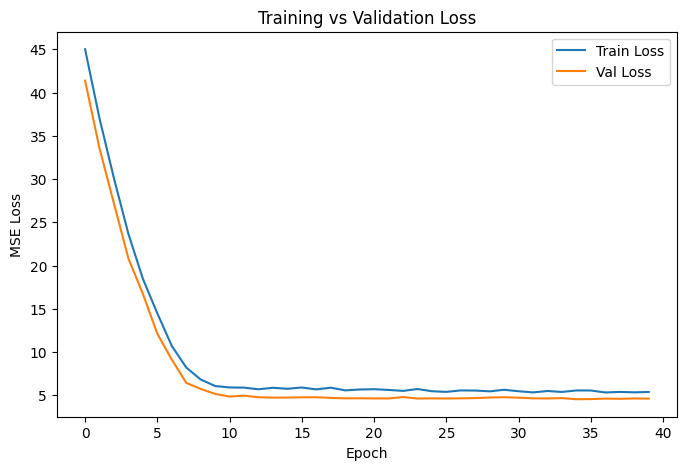

In [31]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


Test MAE:  1.6368
Test MSE:  4.5034
Test RMSE: 2.1221
Test R²:   0.5312


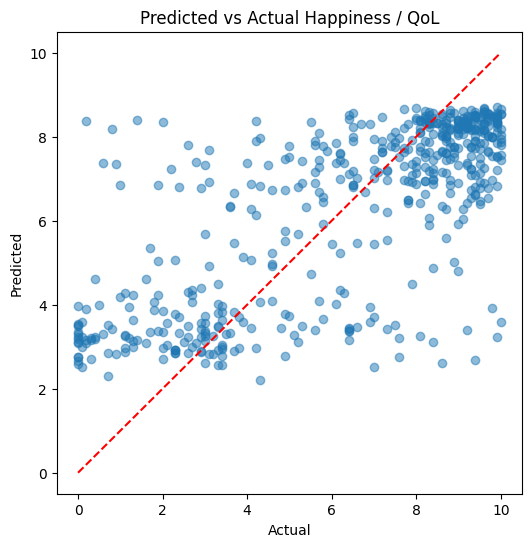

In [32]:
# Evaluate on test set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

mae = mean_absolute_error(all_targets, all_preds)
mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)
r2 = r2_score(all_targets, all_preds)

print(f"Test MAE:  {mae:.4f}")
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²:   {r2:.4f}")

# Scatter plot of predictions vs actual
plt.figure(figsize=(6, 6))
plt.scatter(all_targets, all_preds, alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Happiness / QoL")
plt.plot([all_targets.min(), all_targets.max()],
         [all_targets.min(), all_targets.max()],
         "r--")
plt.show()



In [33]:
# Save trained model for deployment
import os
os.makedirs("../deployment/model", exist_ok=True)

torch.save(model.state_dict(), "../deployment/model/best_model.pt")
print("Model saved!")


Model saved!
